# Set up environment

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
# Test if GPU is available
# Note that CUDA below 12.1 can have bugs
import torch
print(torch.cuda.is_available())
# print(torch.cuda.get_device_name(0))
print(torch.version.cuda)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

True
12.1


In [3]:
#%% import libraries
import os
from collections import defaultdict
import sys

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import copy
import numpy as np
import numpy.random
from numpy.fft import fft as fft
from numpy.fft import ifft as ifft
import pickle
from sklearn.linear_model import PoissonRegressor
from sklearn.model_selection import KFold
from sklearn.manifold import TSNE
import scipy.stats
from scipy.stats import wilcoxon, chi2
import scipy.interpolate 
import scipy.signal
from scipy import linalg
from scipy.special import rel_entr
from tqdm import tqdm
import pandas as pd

import statsmodels.api as sm
import statsmodels.genmod.generalized_linear_model as smm

import torch
from torch.autograd import Variable
from torch.nn import functional as F
import torch.nn as nn
import torch.optim as optim

In [4]:
# import my code
from FCGPFA import gpfa_poisson_fix_weights, make_4d_diagonal, get_K
from FCGPFA import conv, conv_subspace
import utility_functions as utils
import GLM
from DataLoader import Allen_dataset
from model_trainer import Trainer

/home/qix/anaconda3/envs/allen/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Train a model

In [262]:
ckp_path = '/home/qix/user_data/VAETransformer_checkpoint'
data_path = '/home/qix/user_data/allen_spike_trains/cross_session_dataloader.pkl'
with open(data_path, 'rb') as f:
    cross_session_dataloader = pickle.load(f)

torch.manual_seed(0)
np.random.seed(0)

params = {
    'batch_size': 64,
    'beta': 0.1,
    'decoder_architecture': 4,
    'd_model': 128,
    'dim_feedforward': 512,
    'dropout': 0.0,
    'weight_decay': 0.0,
    'lr_transformer': 0.0001,
    'lr_sti': 0.01,
    'lr_cp': 0.01,
    'epoch_warm_up': 10,
    'epoch_fix_latent': 0,
    'epoch_patience': 5,
    'epoch_max': 100,
    'nfactor': 4,
    'nhead': 2,
    'nl_dim': 16,
    'num_B_spline_basis': 20,
    'num_layers': 2,
    'num_merge': 10,
    'sample_latent': False,
    'K_tau': 100,
    'K_sigma2': 1.0,
    'nsubspace': 1,
    'nlatent': 1,
    'coupling_basis_num': 3,
    'coupling_basis_peaks_max': 20,
    'use_self_coupling': True,
    'penalty_overlapping': None,
    }

trainer = Trainer(spikes, ckp_path, params, npadding=npadding)
trainer.train(verbose=True, only_stimulus=True, fix_stmulus=False, fix_latents=True)
trainer.train(verbose=True, only_stimulus=False, fix_stmulus=False, fix_latents=True)

Start training model with parameters: {'batch_size': 64, 'beta': 0.1, 'decoder_architecture': 4, 'd_model': 128, 'dim_feedforward': 512, 'dropout': 0.0, 'weight_decay': 0.0, 'lr_transformer': 0.0001, 'lr_sti': 0.01, 'lr_cp': 0.01, 'epoch_warm_up': 10, 'epoch_fix_latent': 0, 'epoch_patience': 5, 'epoch_max': 100, 'nfactor': 4, 'nhead': 2, 'nl_dim': 16, 'num_B_spline_basis': 20, 'num_layers': 2, 'num_merge': 10, 'sample_latent': False, 'K_tau': 100, 'K_sigma2': 1.0, 'nsubspace': 1, 'nlatent': 1, 'coupling_basis_num': 3, 'coupling_basis_peaks_max': 20, 'use_self_coupling': True, 'penalty_overlapping': None}
Data processed. Train set size: 504, Test set size: 126
Model initialized. Training on cuda
Epoch 1/100, Train Loss: 0.0330, Test Loss: 0.0324
Epoch 2/100, Train Loss: 0.0324, Test Loss: 0.0320
Epoch 3/100, Train Loss: 0.0320, Test Loss: 0.0316
Epoch 4/100, Train Loss: 0.0315, Test Loss: 0.0310
Epoch 5/100, Train Loss: 0.0308, Test Loss: 0.0302
Epoch 6/100, Train Loss: 0.0300, Test Los

0.02665804885327816

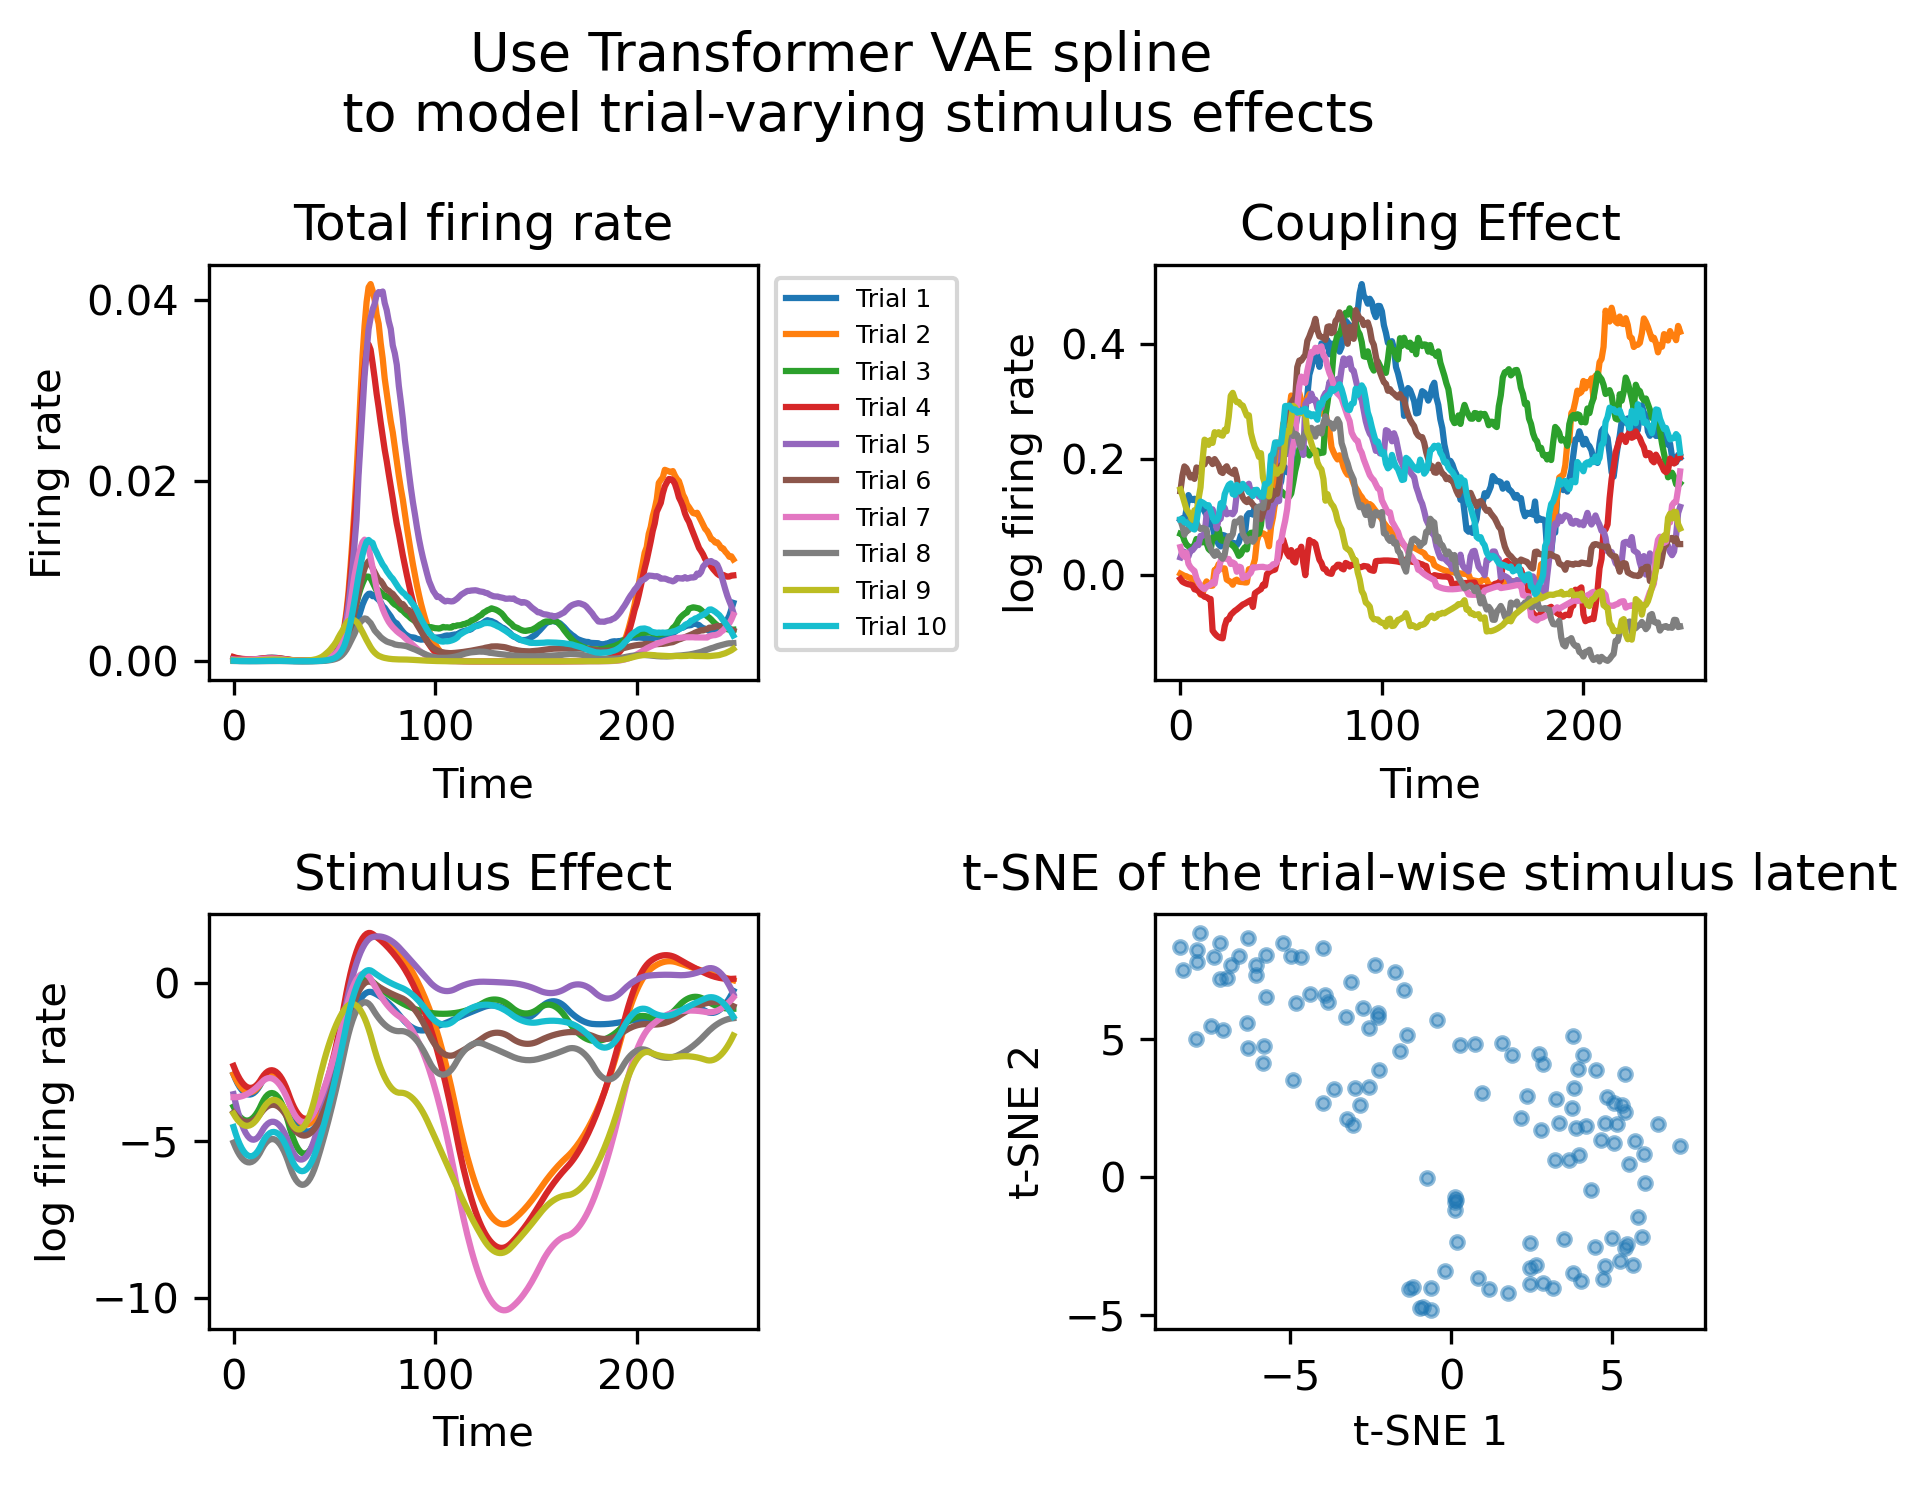

In [263]:
firing_rate_test, sti_mu_test, sti_logvar_test = trainer.predict(return_torch=True, dataset='test', 
                                       only_stimulus=False, fix_stmulus=False, fix_latents=True)

# Create a 2x2 subplot figure
fig, axes = plt.subplots(2, 2, figsize=(6, 5) ,dpi=300)
fig.suptitle('Use Transformer VAE spline \n to model trial-varying stimulus effects', fontsize=13)

# Plot total firing rate
axes[0,0].plot(np.exp(firing_rate_test[100:110, 150, :].numpy().T))
axes[0,0].set_title('Total firing rate')
axes[0,0].set_xlabel('Time')
axes[0,0].set_ylabel('Firing rate')
axes[0,0].legend([f'Trial {i+1}' for i in range(trainer.model.firing_rates_stimulus.shape[2])], 
                 bbox_to_anchor=(1.01, 1), loc='upper left', fontsize=6)

# Plot coupling effect
axes[0,1].plot(trainer.model.firing_rates_coupling[100:110, 150, :].cpu().numpy().T)
axes[0,1].set_title('Coupling Effect')
axes[0,1].set_xlabel('Time')
axes[0,1].set_ylabel('log firing rate')

# Plot stimulus effect
axes[1,0].plot(trainer.model.firing_rates_stimulus[100:110, 150, :].cpu().numpy().T)
axes[1,0].set_title('Stimulus Effect')
axes[1,0].set_xlabel('Time')
axes[1,0].set_ylabel('log firing rate')

# Plot t-SNE in the last subplot
tsne = TSNE(n_components=2, random_state=42)
sti_mu_test_np = sti_mu_test.detach().cpu().numpy() if torch.is_tensor(sti_mu_test) else sti_mu_test
sti_mu_test_tsne = tsne.fit_transform(sti_mu_test_np)
axes[1,1].scatter(sti_mu_test_tsne[:, 0], sti_mu_test_tsne[:, 1], alpha=0.5, marker='.')
axes[1,1].set_title('t-SNE of the trial-wise stimulus latent')
axes[1,1].set_xlabel('t-SNE 1')
axes[1,1].set_ylabel('t-SNE 2')

plt.tight_layout()
plt.savefig('Figure/all_effects_and_tsne0.pdf', bbox_inches='tight', dpi=300)

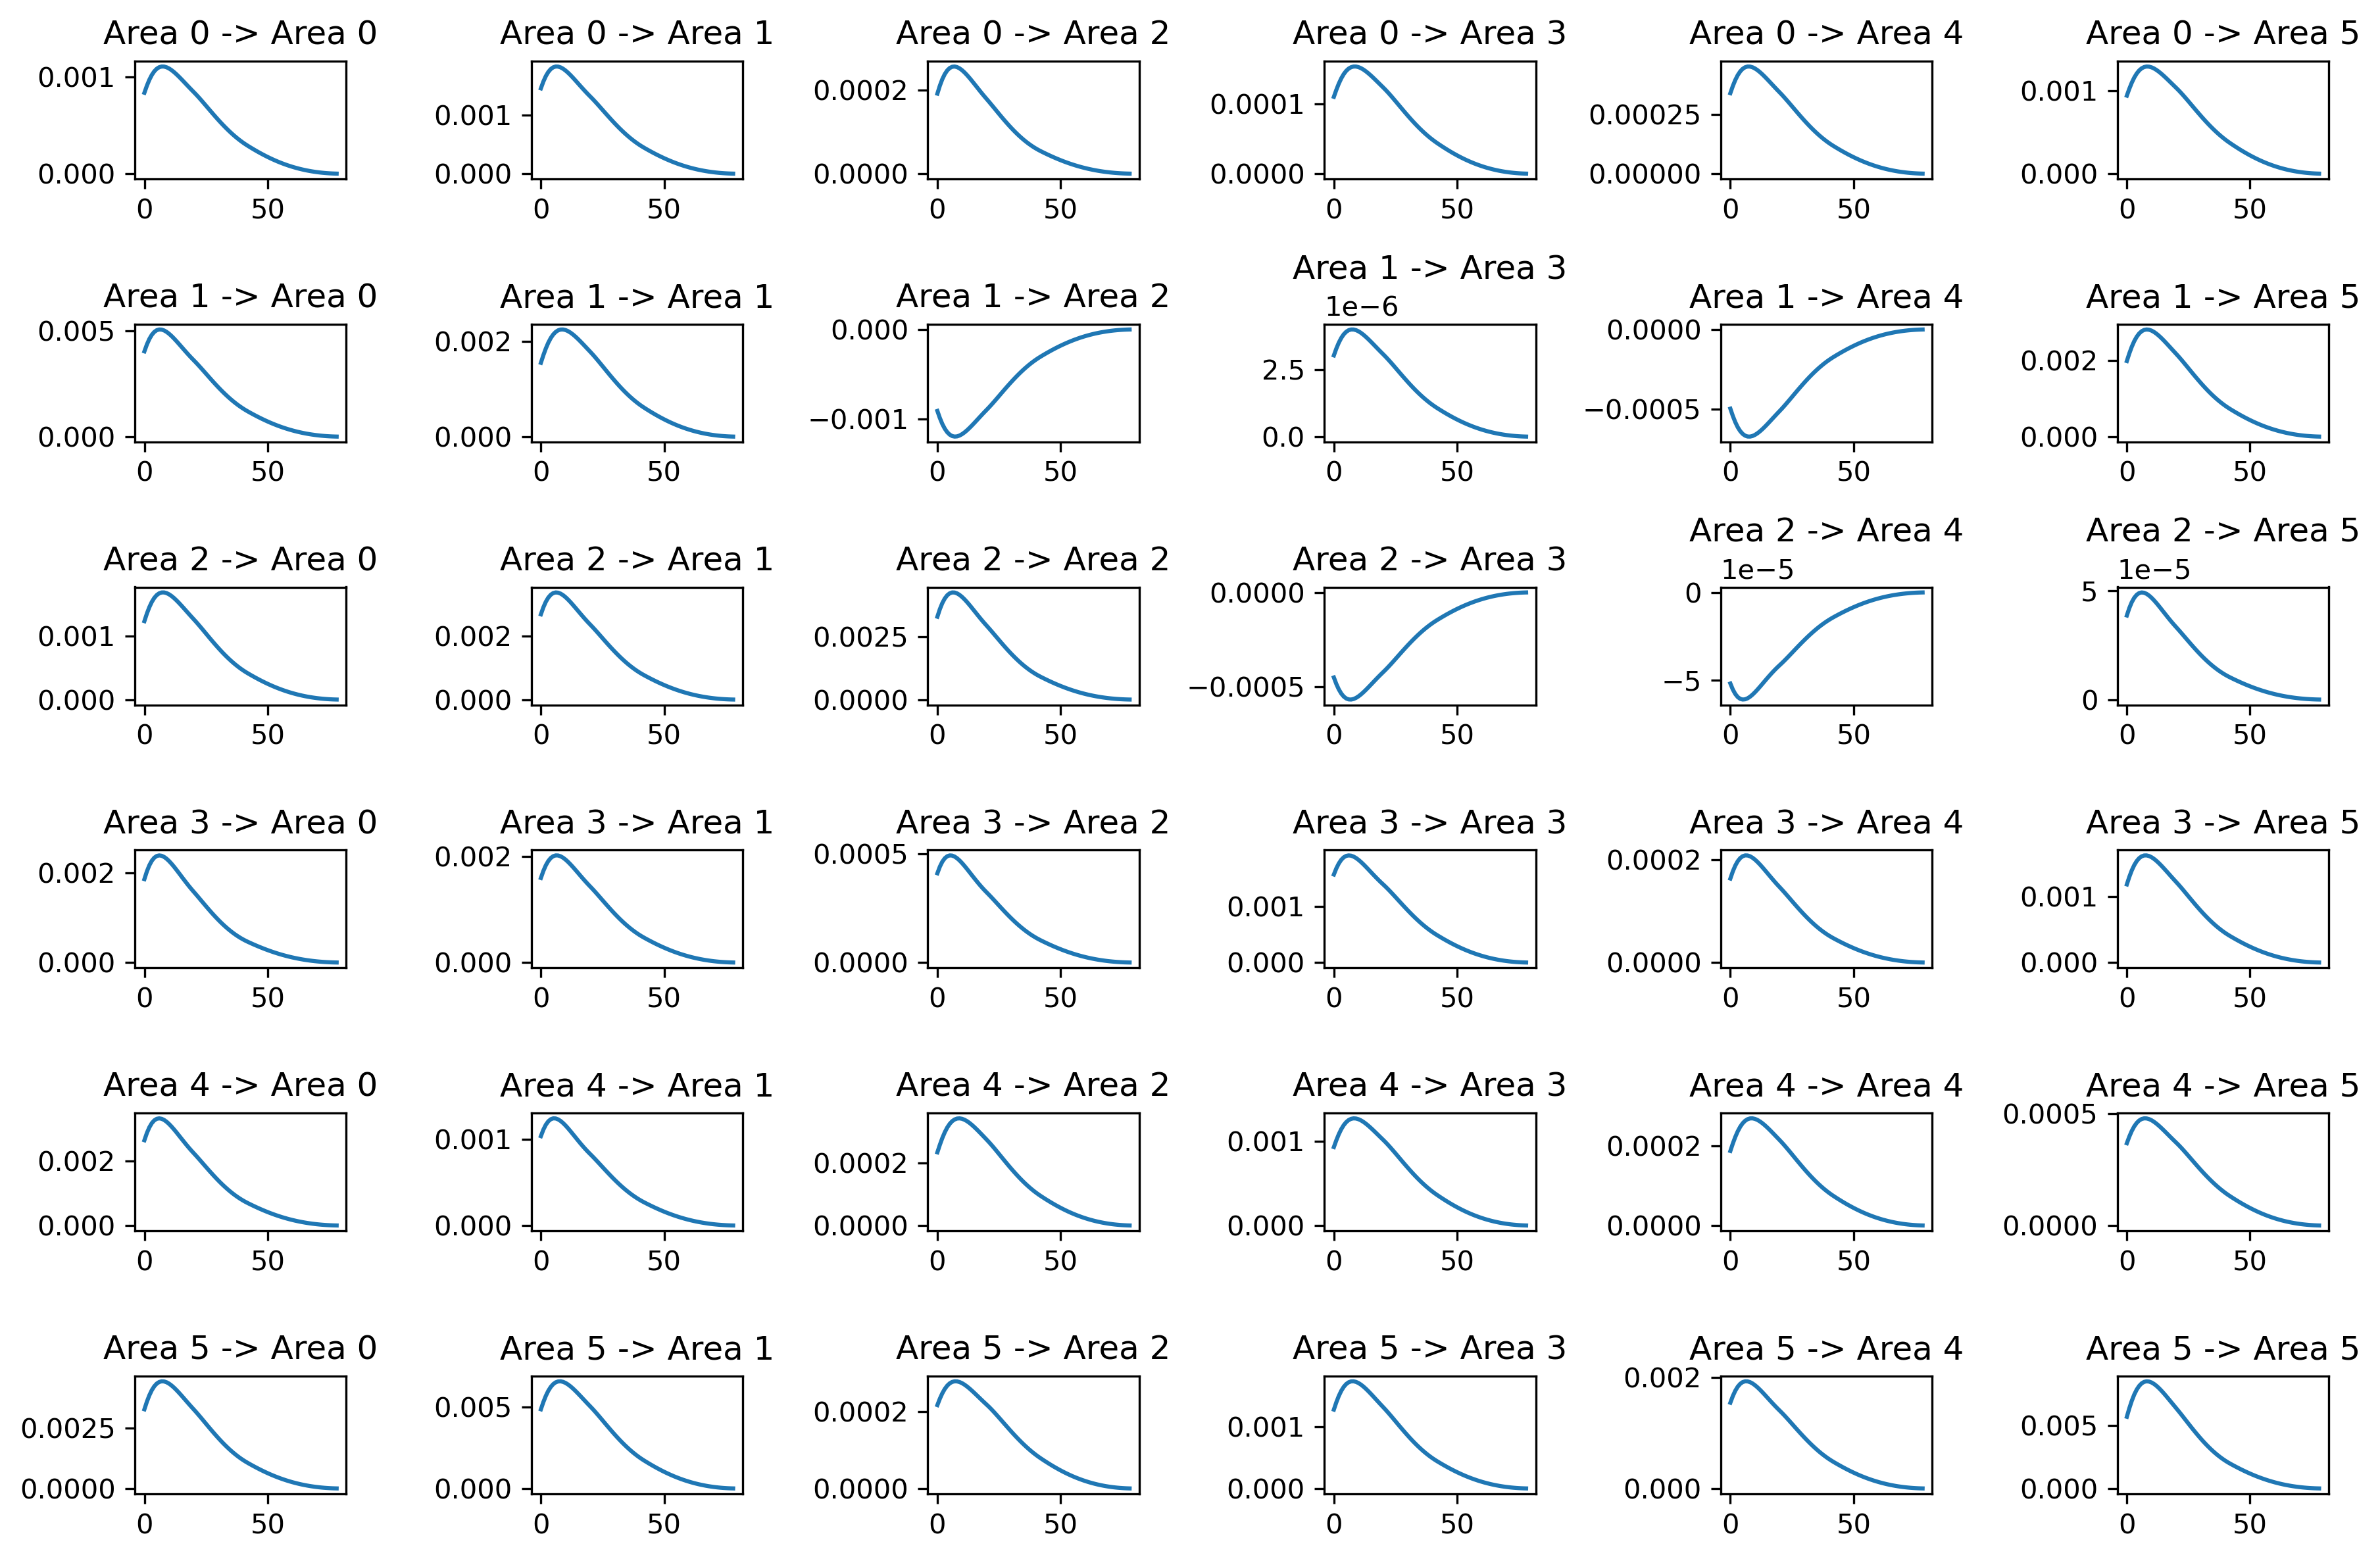

In [215]:
# Create a figure with N x N subplots for each area pair
narea = len(trainer.model.coupling_filters)
fig, axes = plt.subplots(narea, narea, figsize=(12, 8), dpi=300)

# Plot coupling filters for each area pair
for i in range(narea):
    for j in range(narea):
        filters = (
            trainer.model.coupling_filters[i][j].detach().cpu().numpy()
            * trainer.model.cp_weight_sending[i][j].mean().detach().cpu().numpy()
            * trainer.model.cp_weight_receiving[i][j].mean().detach().cpu().numpy() 
        )
        axes[i,j].plot(filters[:,0])
        axes[i,j].set_title(f'Area {i} -> Area {j}')

plt.tight_layout()
plt.show()
